# Imports

In [1]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import joblib
import os.path
from messaging.telegrambot import Bot
import telegram
import sys
sources_path = './../Sources'
if sources_path not in sys.path:
    sys.path.append(sources_path)
from Evaluations.metrics import MSE, RMSE, MAE
import os
#sys.path.append('../Sources') # Adding my own libs source
#from StackedAutoEncoderRS.SAERS import SAE

# Defining Constant Variables

In [2]:
%matplotlib inline
results_path = './Results/'
verbose = True

# Loading Dataset

In [3]:
#Loading dataset

dataset = '100k/' #100k dataset path
#dataset = '10M/' #10M dataset path
#dataset = '20M/' #20M dataset path

dataset_path = '../../Datasets/movieLens/' + dataset; # Full dataset path

filenames = {'movie': 'movie.csv', 'rating': 'rating.csv'};

time_zero = time.time();
#df_movies = pd.read_csv(dataset_path+filenames['movie'], error_bad_lines=False);
#print "[Loading Time:",time.time()-time_zero,"s]",filenames['movie'],'Shape: ', df_movies.shape;

#print df_movies.head();
#print df_movies.tail();

df_ratings = pd.read_csv(dataset_path+filenames['rating']);
print "[Loading Time:",time.time()-time_zero,"s]",filenames['rating'],'Shape: ', df_ratings.shape;


[Loading Time: 0.159054040909 s] rating.csv Shape:  (100000, 4)


In [4]:
df_ratings.head()

,userId,itemId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


# Creating Recommender Class

In [10]:
class Recommender:
    def __init__(self, algorithm):
        
        # Always call base method before doing anything.
        self.name = algorithm.lower() # SVD, NMF, SAE, LSTM
        self.surprise_algorithms = ['svd', 'nmf', 'knn_basic', 'knn_means']
        
        '''
         To implement with surprise:
             - Matrix-Factorization Based:
                 SVDpp: The SVD++ algorithm, an extension of SVD taking into account implicit ratings.
             - Neighbourhood-based:
                 Coclustering
                 KNNWithZScore: A basic collaborative filtering algorithm, taking into account the z-score normalization of each user.
                 KNNBaseline: A basic collaborative filtering algorithm taking into account a baseline rating.
             - Random Predictor    
                 NormalPredictor: Algorithm predicting a random rating based on the distribution of the training set, which is assumed to be normal.
             - Baseline    
                 BaselineOnly: Algorithm predicting the baseline estimate for given user and item.
             - Slope One
                 SlopeOne: A simple yet accurate collaborative filtering algorithm.

        To implement using RNN:
            - LSTM 
            - GRU (Devooght, Bersini)
            - GRU with clustering (Devooght, Bersini)
            
        To extract latent factors:
            - Stacked Autoencoders
            - CNN
            - CNN with Stacked Autoencoders
        '''
        
        self.df_known_predictions = None
        self.df_unknown_predictions = None
        self.k = None
        self.k_min = None
        
    def get_name(self, verbose = False):
        return self.name

    def fit(self, 
            df_ratings = None, 
            columns = ['userId', 'itemId', 'rating'],             
            verbose = False,
           **kwargs):
        
        # If Surprise lib is the base package to fit, then df_ratings must be used. 
        # Algorithms that use Surprise Lib: NMF, SVD, KNN, SVDpp
        
        if (df_ratings is not None):
            self.df_ratings = df_ratings
        
        ###########################################
        # Convert Utility Matrix to df_ratings if utility matrix is passed
        #
        #
        ###########################################
        
        if self.name in self.surprise_algorithms:  # Surprise-based recommenders          
            from surprise import Dataset
            from surprise import Reader
            
            # A reader is still needed but only the rating_scale param is required.
            # The Reader class is used to parse a file containing ratings.
            reader = Reader(rating_scale=(0.5, 5.0))
            
            # The columns must correspond to user id, item id and ratings (in that order).
            data = Dataset.load_from_df(df_ratings[columns], reader)

            # Creting trainset variable to be used in prediction functions of Surprise
            self.trainset = data.build_full_trainset()

            
            # Creating Model
            if self.name == 'svd':                
                from surprise import SVD
                
                # Setting Number of Factors in Matrix Factorization
                if ('n_factors' in kwargs):
                    self.n_factors = kwargs['n_factors']
                else:
                    self.n_factors = 100
                    if (verbose):
                        print ("Using default number of factors: {}".format(self.n_factors))                                                
                
                # Setting number of epochs in stocastic gradient descent
                if ('n_epochs' in kwargs):
                    self.n_epochs = kwargs['n_epochs']
                else:
                    self.n_epochs = 20
                    if (verbose):
                        print ("Using default number of epochs: {}".format(self.n_epochs))                                                
                
                self.model = SVD(n_factors = self.n_factors, n_epochs = self.n_epochs, verbose = verbose)
                
                
            elif self.name == 'nmf':
                from surprise import NMF
                
                # Setting Number of Factors in Matrix Factorization
                if ('n_factors' in kwargs):
                    self.n_factors = kwargs['n_factors']
                else:
                    self.n_factors = 15
                    if (verbose):
                        print ("Using default number of factors: {}".format(self.n_factors))                                                
                
                # Setting number of epochs in stocastic gradient descent
                if ('n_epochs' in kwargs):
                    self.n_epochs = kwargs['n_epochs']
                else:
                    self.n_epochs = 50
                    if (verbose):
                        print ("Using default number of epochs: {}".format(self.n_epochs))                                                
                
                self.model = NMF(n_factors = self.n_factors, n_epochs = self.n_epochs, verbose = verbose)
               
                
            elif self.name == 'knnbasic':
                from surprise import KNNBasic
                
                # Setting number of neighbours
                if ('k' in kwargs):
                    self.k = kwargs['k']
                else:
                    self.k = 40
                    if (verbose):
                        print ("Using default k: {}".format(self.k))                                                
                     
                # Setting minimum number of neighbours
                if ('k_min' in kwargs):
                    self.k_min = kwargs['k_min']
                else:
                    self.k_min = 1
                    if (verbose):
                        print ("Using default k_min: {}".format(1))                         
                        
                self.model = KNNBasic(k = self.k, min_k = self.k_min, verbose = verbose)

                
            elif self.name == 'kmeans':
                from surprise import KNNWithMeans
                
                # Setting number of neighbours
                if ('k' in kwargs):
                    self.k = kwargs['k']
                else:
                    self.k = 40
                    if (verbose):
                        print ("Using default k: {}".format(40))                                                
                        
                # Setting minimum number of neighbours
                if ('k_min' in kwargs):
                    self.k_min = kwargs['k_min']
                else:
                    self.k_min = 1
                    if (verbose):
                        print ("Using default k_min: {}".format(1))                                                
                        
                self.model = KNNWithMeans(k = self.k, min_k = self.k_min, verbose=verbose)
                
            else:
                if (verbose):
                    print ("Algorithm not configured: {}".format(self.name))
                return 0

            # Train the algorithm on the trainset, and predict ratings for the testset
            self.model.train(self.trainset)
        else: # if self.name not in self.surprise_algorithms
            if (verbose): 
                print ("Invalid algorithm: {}".format(self.name))
            
    def get_model(self):
        return self.model
            
    def calculate_known_predictions(self):
        # Calculating all predictions for known items
        
        if self.name in self.surprise_algorithms:    
            # Calculating predictions dataframe as userId, itemId, rating, prediction
            # predictions return raw uid and iid           
            
            known_predictions = self.model.test(self.trainset.build_testset()) # Brings all predictions of existing ratings

            for prediction in known_predictions:    
                arr = np.array([int(prediction.uid), int(prediction.iid), prediction.r_ui, prediction.est])
                if prediction == known_predictions[0]:        
                    predictions = np.array([arr])
                else:
                    predictions = np.append(predictions, [arr], axis = 0)

            self.df_known_predictions = pd.DataFrame({'userId':predictions[:,0],'itemId':predictions[:,1], 'rating': predictions[:,2], 'prediction': predictions[:,3]})

    def get_known_predictions(self, calculate_predictions = False):
        if self.df_known_predictions is None or calculate_predictions == True:
            self.calculate_known_predictions()
        
        return self.df_known_predictions
    
    def calculate_unknown_prediction(self):
        # Calculating all predictions for known items
        # predictions return raw uid and iid
        
        if self.name in self.surprise_algorithms:            
            unknown_predictions = self.model.test(self.trainset.build_anti_testset()) # => Brings all predictions of non-existing ratings

            for prediction in unknown_predictions:    
                arr = np.array([int(prediction.uid), int(prediction.iid), 0, prediction.est])
                if prediction == unknown_predictions[0]:        
                    predictions = np.array([arr])
                else:
                    predictions = np.append(predictions, [arr], axis = 0)

            self.df_unknown_predictions = pd.DataFrame({'userId':predictions[:,0],'itemId':predictions[:,1], 'rating': predictions[:,2], 'prediction': predictions[:,3]})
            
    def get_unknown_predictions(self, calculate_predictions = False):
        if self.df_unknown_predictions is None or calculate_predictions == True:
            self.calculate_unknown_predictions()
        
        return self.df_unknown_predictions        
            
    def predict(self, userId, itemId, verbose = False):
        
        if self.name in self.surprise_algorithms:
            prediction = self.model.predict(uid = int(userId), iid = int(itemId)) # Take as input the raw user id and item id
            #ref: http://surprise.readthedocs.io/en/stable/algobase.html#surprise.prediction_algorithms.algo_base.AlgoBase.predict
            
            if prediction.details['was_impossible'] == True:
                if (verbose):
                    print ("Impossible to predict item {} rating for user {} (one of them may not have been in training step)".format(itemId, userId))
                return 0            
            else:
                return prediction.est
    
    def get_top_n(self, n=10, source = 'unknown'):
        '''Return the top-N recommendation for each user from a set of predictions.
        Args:        
            n(int): The number of recommendation to output for each user. Default
                is 10.
        Returns:
        A dict where keys are user (raw) ids and values are lists of tuples:
            [(raw item id, rating estimation), ...] of size n. 

        if (source.lower() == 'unknown'):
        # First map the predictions to each user.
            top_n = defaultdict(list)
            for uid, iid, r_ui, est, _ in self.unknown_predictions:
                top_n[uid].append((iid, est))
                
        else:
        # First map the predictions to each user.
            top_n = defaultdict(list)
            for uid, iid, r_ui, est, _ in self.known_predictions:
                top_n[uid].append((iid, est))

        # Then sort the predictions for each user and retrieve the k highest ones.
        for uid, user_ratings in top_n.items():
            user_ratings.sort(key=lambda x: x[1], reverse=True)

            #user_ratings = map(lambda uid: self.trainset.to_raw_uid(uid) , user_ratings)

            top_n[uid] = user_ratings[:n]'''

        return 1 #top_n

    


# Creating Recommender Instance

In [11]:
%%time

rs = Recommender(algorithm = 'svd')
print rs.get_name()
rs.fit(df_ratings = df_ratings, n_epochs = 10, n_factors = 40, verbose = True)

svd
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
CPU times: user 2.02 s, sys: 0 ns, total: 2.02 s
Wall time: 3.75 s


# Getting Predictions for a Single User

In [12]:
#rs.get_top_n(10)
#rs.get_model()
print (rs.predict(userId = 196, itemId = 242))

4.06923384376


# Evaluating Algorithm

In [132]:
def saveVariable(results_path, dataset, filename, variable, compression_parameter = 9, verbose = False):
    import os.path
    
    compression_parameter = 9;
    
    filepath = results_path+"Variables/"+dataset+filename
    
    if (verbose):    
        print ("[*] Saving variable to {} file".format(filepath))
        
    #Check if file already exists
    if os.path.isfile(filepath): 
        if (verbose):
            print ("[*] Removing existing file")            
        os.remove(filepath);
      
    #joblib.dump(value, filename, compress=0, protocol=None, cache_size=None)
    joblib.dump(variable, filepath, compress = compression_parameter);
    
    if (verbose):
        print ("[+] File saved.")   

def saveFigure(results_path, dataset, filename, fig, verbose = False):
    fullpath = results_path + 'Figures/' + dataset + filename
    
    if (verbose):
        print "[*] Saving plot to {} folder",format(fullpath)
        
    fig.savefig(fullpath)
    
    if (verbose):
        print "[+] Results saved."
        
def loadVariable(results_path, dataset, filename, compression_parameter = 9, verbose = False):
    filepath = results_path+"Variables/"+dataset+filename
    if (verbose):
        print ("Loading variable from {}".format(filepath))
    
    variable = joblib.load(filepath)
    
    if (verbose):
        print ("Variable loaded")
    
    return variable
        
#k_evaluations = dict()
#k_evaluations[4] = {'mae': 0.4, 'rmse': 0.5}
#saveVariable(results_path=results_path, dataset = dataset, variable = k_evaluations, filename = 'knn_evaluations_dic', verbose = True)
#loadVariable(results_path=results_path, dataset = dataset, filename = 'knn_evaluations_dic', verbose = True)

## Getting Predictions of Known Ratings

In [13]:
%%time
df_known_predictions = rs.get_known_predictions(calculate_predictions = False)

KeyboardInterrupt: 

In [134]:
print (MSE(df_known_predictions['rating'], df_known_predictions['prediction']))
print (RMSE(df_known_predictions['rating'], df_known_predictions['prediction']))
print (MAE(df_known_predictions['rating'], df_known_predictions['prediction']))

df_known_predictions.head()

0.615076640938
0.784268220023
0.620007043587


,itemId,prediction,rating,userId
0,242.0,4.089550,3.0,196.0
1,393.0,3.601198,4.0,196.0
2,381.0,3.462450,4.0,196.0
3,251.0,4.023073,3.0,196.0
4,655.0,3.740709,5.0,196.0


## Evaluating Number of Neighbours on KNN-Based-Algorithms

In [ ]:
%%time
knn_based_algorithms = ['knnbasic', 'kmeans']
k_array = np.arange(10, 111, 5)

for algorithm in knn_based_algorithms:    
    time_zero = time.time()
    rs = Recommender(algorithm = algorithm)
    print ("----------------------------------------------------")
    print ("Calculating evaluations for {}".format(rs.get_name()))
    
    knn_predictions = dict()
    
    for k in k_array:            
        # Fitting Algorithm
        rs.fit(df_ratings = df_ratings, k = k, verbose = False)
        
        # Getting Known Predictions
        df_known_predictions = rs.get_known_predictions(calculate_predictions = True)
        
        # Evaluating Known Predictions
        mae = MAE(df_known_predictions['rating'], df_known_predictions['prediction'])
        rmse = RMSE(df_known_predictions['rating'], df_known_predictions['prediction'])
        mse = MSE(df_known_predictions['rating'], df_known_predictions['prediction'])
        
        k_evaluations[k] = {'mae': mae, 'rmse': rmse, 'mse': mse}
        
    # Saving evaluations
    saveVariable(results_path = results_path, dataset = dataset, variable = k_evaluations, filename = '{}_evaluations_dic'.format(algorithm), verbose = True)
    print ("Elapsed time for {}: {}".format(rs.get_name(), time.time()-time_zero))

----------------------------------------------------
Calculating evaluations for knnbasic
Computing the msd similarity matrix...
Done computing similarity matrix.


Loading variable from ./Results/Variables/100k/knnbasic_evaluations_dic
Variable loaded
[*] Saving plot to {} folder ./Results/Figures/100k/knnbasic_evaluations_per_neighbours.png
[+] Results saved.
Loading variable from ./Results/Variables/100k/kmeans_evaluations_dic
Variable loaded
[*] Saving plot to {} folder ./Results/Figures/100k/kmeans_evaluations_per_neighbours.png
[+] Results saved.


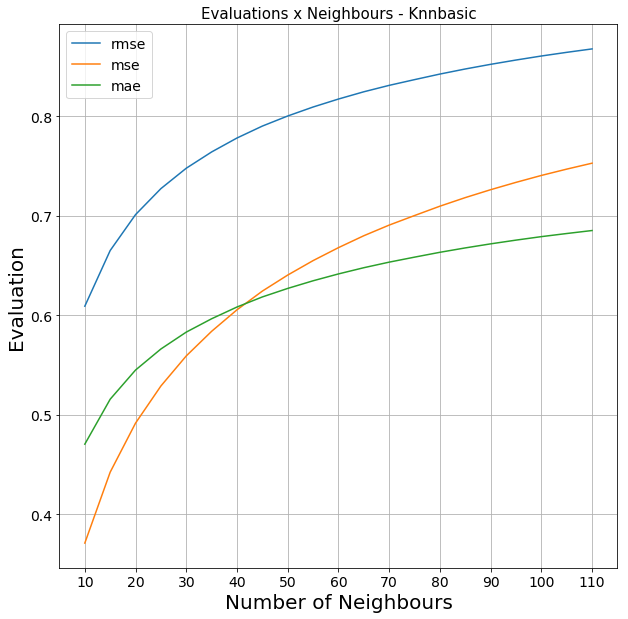

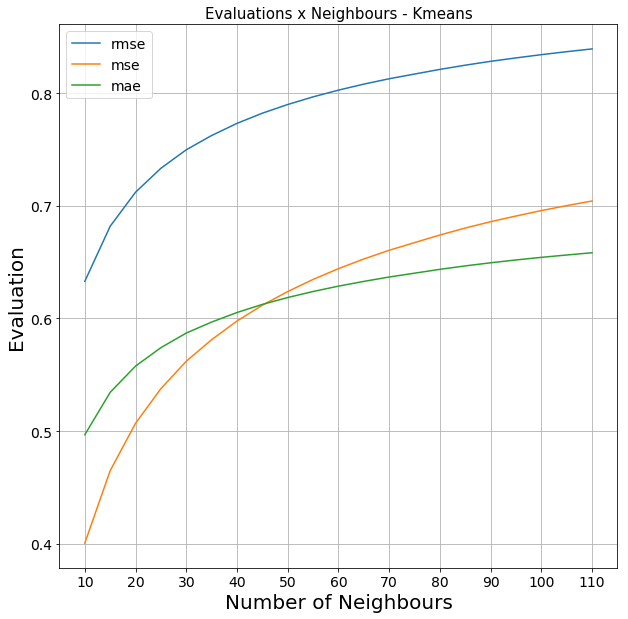

In [126]:
# Loading algorithm evaluations variable
for algorithm in knn_based_algorithms:
    #algorithm = 'kmeans'#'knnbasic'
    k_evaluations = loadVariable(results_path=results_path, dataset = dataset, filename = '{}_evaluations_dic'.format(algorithm), verbose = verbose)

    # Converting Dictionary to array
    k_array = np.array([])
    rmse_array = np.array([])
    mae_array = np.array([])
    mse_array = np.array([])

    for key in sorted(k_evaluations.keys()):
        k_array = np.append(k_array, int(key))
        rmse_array = np.append(rmse_array, k_evaluations[key]['rmse'])
        mse_array = np.append(mse_array, k_evaluations[key]['mse'])
        mae_array = np.append(mae_array, k_evaluations[key]['mae'])

    # Plotting Evaluations
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(k_array, rmse_array, label = 'rmse')
    ax.plot(k_array, mse_array, label = 'mse')
    ax.plot(k_array, mae_array, label = 'mae')
    #ax.axis([0, k_array[-1], 0, itemsQuantity[-1]])
    ax.grid(True)
    ax.legend(fontsize = 14)
    ax.set_xticks([x for x in xrange (int(k_array[0]), int(k_array[-1])+1, 10)])
    #ax.set_yticks([x for x in xrange (0, itemsQuantity[-1], 100)])

    ax.set_xlabel('Number of Neighbours', fontsize = 20)
    ax.set_ylabel('Evaluation', fontsize = 20)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_title('Evaluations x Neighbours - {}'.format(algorithm.title()), fontsize = 15)

    saveFigure(results_path, dataset, '{}_evaluations_per_neighbours.png'.format(algorithm), fig, verbose = True)

## Evaluating Number of Factors on Matrix Factorization-based Algorithms

In [ ]:
%%time
matrix_factorization_based_algorithms = ['svd']
n_factors_array = np.arange(70, 311, 20)

for algorithm in matrix_factorization_based_algorithms:    
    time_zero = time.time()
    rs = Recommender(algorithm = algorithm)
    print ("----------------------------------------------------")
    print ("Calculating evaluations for {}".format(rs.get_name()))
    
    matrix_factorization_evaluations = dict()
    
    for n_factors in n_factors_array:            
        # Fitting Algorithm
        rs.fit(df_ratings = df_ratings, n_factors = n_factors, verbose = False)
        
        # Getting Known Predictions
        df_known_predictions = rs.get_known_predictions(calculate_predictions = True)
        
        # Evaluating Known Predictions
        mae = MAE(df_known_predictions['rating'], df_known_predictions['prediction'])
        rmse = RMSE(df_known_predictions['rating'], df_known_predictions['prediction'])
        mse = MSE(df_known_predictions['rating'], df_known_predictions['prediction'])
        
        matrix_factorization_evaluations[n_factors] = {'mae': mae, 'rmse': rmse, 'mse': mse}
        
    # Saving evaluations
    saveVariable(results_path = results_path, dataset = dataset, variable = matrix_factorization_evaluations, filename = '{}_evaluations_dic'.format(algorithm), verbose = True)
    print ("Elapsed time for {}: {}".format(rs.get_name(), time.time()-time_zero))

----------------------------------------------------
Calculating evaluations for svd


Loading variable from ./Results/Variables/100k/svd_evaluations_dic
Variable loaded
[*] Saving plot to {} folder ./Results/Figures/100k/svd_evaluations_per_factors.png
[+] Results saved.


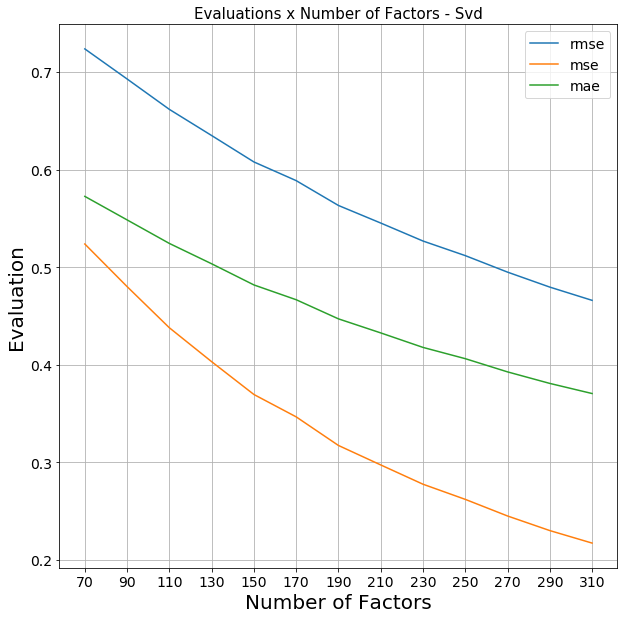

In [142]:
# Loading algorithm evaluations variable
for algorithm in matrix_factorization_based_algorithms:
    #algorithm = 'kmeans'#'knnbasic'
    n_factors_evaluations = loadVariable(results_path=results_path, dataset = dataset, filename = '{}_evaluations_dic'.format(algorithm), verbose = verbose)

    # Converting Dictionary to array
    n_factors_array = np.array([])
    rmse_array = np.array([])
    mae_array = np.array([])
    mse_array = np.array([])

    for key in sorted(n_factors_evaluations.keys()):
        n_factors_array = np.append(n_factors_array, int(key))
        rmse_array = np.append(rmse_array, n_factors_evaluations[key]['rmse'])
        mse_array = np.append(mse_array, n_factors_evaluations[key]['mse'])
        mae_array = np.append(mae_array, n_factors_evaluations[key]['mae'])

    # Plotting Evaluations
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(n_factors_array, rmse_array, label = 'rmse')
    ax.plot(n_factors_array, mse_array, label = 'mse')
    ax.plot(n_factors_array, mae_array, label = 'mae')
    #ax.axis([0, k_array[-1], 0, itemsQuantity[-1]])
    ax.grid(True)
    ax.legend(fontsize = 14)
    ax.set_xticks([x for x in xrange (int(n_factors_array[0]), int(n_factors_array[-1])+1, 20)])
    #ax.set_yticks([x for x in xrange (0, itemsQuantity[-1], 100)])

    ax.set_xlabel('Number of Factors', fontsize = 20)
    ax.set_ylabel('Evaluation', fontsize = 20)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_title('Evaluations x Number of Factors - {}'.format(algorithm.title()), fontsize = 15)

    saveFigure(results_path, dataset, '{}_evaluations_per_factors.png'.format(algorithm), fig, verbose = True)